# Project: Data Analysis

In this project, I want to find the most frequent topics from unstructured complaint texts using Natural Language Processing (NLP) techniques. I selected the dataset “Air France Reviews” from Kaggle, which includes unstructured customer feedback about airline services. These reviews often express detailed complaints and opinions about flight delays, food, staff, and comfort, making them ideal for identifying key topics through NLP.

## Text Preprocessing
* Removing punctuation
* Lowercasing
* Eliminating Stopwords
* Lemmatization

## Vectorization Techniques
* TF-IDF via Sklearn
* Sentence BERT

## Topic Extraction
* LDA
* BERTopic

## Notebook Imports

In [1]:
!pip install sentence-transformers
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attemptin

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from pprint import pprint

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Transformers
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# Gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models.ldamodel import LdaModel, CoherenceModel
from gensim.corpora import Dictionary

# Pytorch 
import torch
import torch.nn as nn

%matplotlib inline

2025-05-19 11:59:25.717557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747655965.981244      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747655966.057530      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/annotation_payload_pb2.py:277: DeprecationWarning: invalid escape sequence '\_'
  __doc__="""Contains annotation information that is relevant to
/usr/local/lib/python3.11/dist-packages/google/cloud/automl_v1/proto/classification_pb2.py:679: DeprecationWarning: invalid escape sequence '\_'
  __doc__="""Metrics for a single confidence threshold.
/usr/local/lib/python3

## Data Loading

In [3]:
dataset = pd.read_csv("/kaggle/input/air-france-reviews-dataset/airfrance_tripadvisor_reviews.csv")
dataset.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,I travel a lot - and I travel often. Last week...,2024-11-13
1,1,Terrible experience with Airfrance,"This review is regarding flight AF185, we book...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,I recently flew with Air France on flight #185...,2024-11-12
3,1,Horrible,Wow!!! What a horrible experience!! I've alway...,2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,I spent a fantastic 10-day vacation in Hong Ko...,2024-11-11


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         2560 non-null   int64 
 1   title          2560 non-null   object
 2   text           2560 non-null   object
 3   publishedDate  2560 non-null   object
dtypes: int64(1), object(3)
memory usage: 80.1+ KB


In [5]:
dataset.duplicated().sum()

0

In [6]:
dataset.shape

(2560, 4)

## Data Visualization

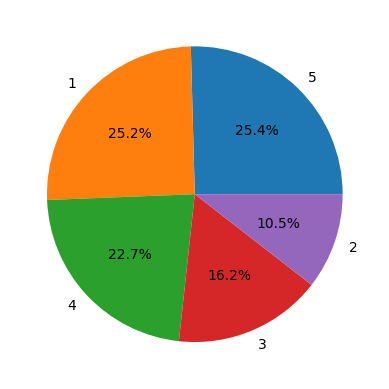

In [7]:
rating = dataset['rating'].value_counts()
labels = rating.keys()
plt.pie(rating, labels=labels, autopct='%1.1f%%')
plt.show()

## Data Cleaning

In [8]:
def preprocess_text(text: str, stopwords=set(stopwords.words('english')), wnl=WordNetLemmatizer()):
    
    """
    Preprocesses the input text by tokenizing, removing stopwords and punctuation, and lemmatizing the words.
    
    Args:
        text (str): The input text to be preprocessed.
        stopwords (set, optional): A set of stopwords to be removed from the text. Defaults to nltk's English stopwords.
        wnl (WordNetLemmatizer, optional): An instance of WordNetLemmatizer for lemmatizing words. Defaults to an instance of WordNetLemmatizer.
        
    Returns:
        list or str: The preprocessed text. 
    """
    
    # Tokenising
    words = word_tokenize(text.lower())
    
    # Removing Stopwords & Punctuation
    filtered_text = [word for word in words if word not in stopwords and word.isalpha()]
    
    # Lemmatization
    preprocessed_text = [wnl.lemmatize(word) for word in filtered_text]
    
    return preprocessed_text

In [9]:
dataset['text'] = dataset['text'].apply(preprocess_text)
dataset.head()

,rating,title,text,publishedDate
0,1,WORST AIRLINE,"[travel, lot, travel, often, last, week, flew,...",2024-11-13
1,1,Terrible experience with Airfrance,"[review, regarding, flight, booked, economy, f...",2024-11-13
2,1,Extremely Disappointing Experience with Air Fr...,"[recently, flew, air, france, flight, hong, ko...",2024-11-12
3,1,Horrible,"[wow, horrible, experience, always, flown, por...",2024-11-11
4,1,The Worst Flight Experience I’ve Ever Had,"[spent, fantastic, vacation, hong, kong, famil...",2024-11-11


In [10]:
dataset.drop(['title', 'publishedDate'], axis=1, inplace=True)
dataset.head()

,rating,text
0,1,"[travel, lot, travel, often, last, week, flew,..."
1,1,"[review, regarding, flight, booked, economy, f..."
2,1,"[recently, flew, air, france, flight, hong, ko..."
3,1,"[wow, horrible, experience, always, flown, por..."
4,1,"[spent, fantastic, vacation, hong, kong, famil..."


In [11]:
len(dataset.text.max())

115

## Text Vectorization

###  TF-IDF via Sklearn → based on word **frequency**

In [12]:
dataset['cleaned_text'] = dataset['text'].apply(" ".join)
documents = [item for item in dataset['cleaned_text']]

In [13]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, ngram_range=(1,2))
vectors = vectorizer.fit_transform(documents)
vectors.shape

(2560, 2444)

In [14]:
feature_names = vectorizer.get_feature_names_out()

In [15]:
tfidf_df = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,ability,able,able get,aboard,absolute,absolutely,accept,acceptable,access,accommodating,...,wrote,year,year ago,year old,yes,yet,york,young,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.045582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


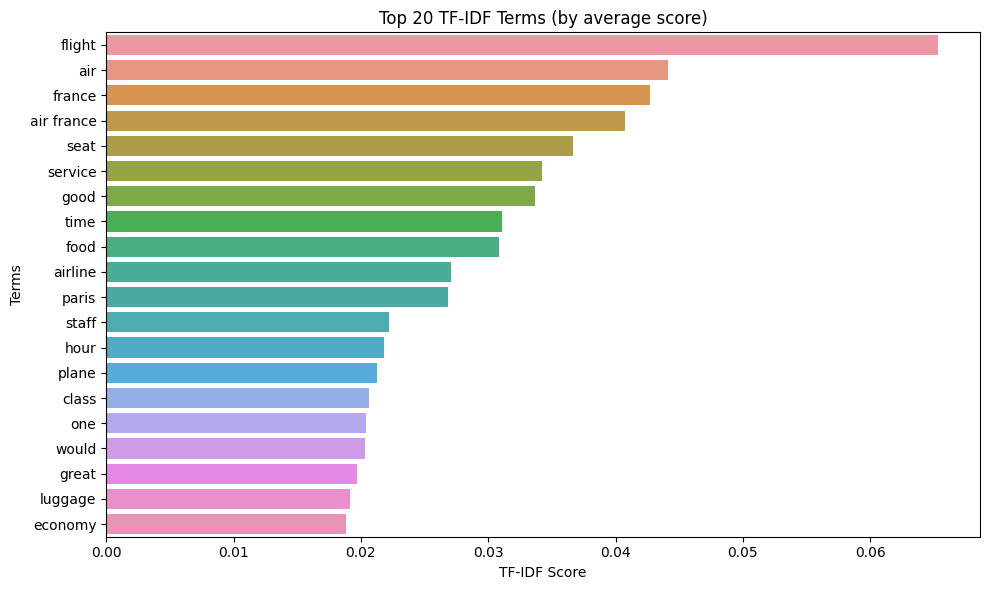

In [16]:
tfidf_means = np.asarray(vectors.mean(axis=0)).flatten()
top_indices = tfidf_means.argsort()[::-1][:20]
top_terms = [feature_names[i] for i in top_indices]
top_scores = tfidf_means[top_indices]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_terms)
plt.title("Top 20 TF-IDF Terms (by average score)")
plt.xlabel("TF-IDF Score")
plt.ylabel("Terms")
plt.tight_layout()
plt.show()

###  BERT → based on **meaning**

In [17]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sentence_model.encode(documents)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/80 [00:00<?, ?it/s]

In [18]:
emdeddings_df = pd.DataFrame(embeddings)
emdeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.069206,-0.066198,0.026900,0.030805,0.066946,-0.013750,0.085353,-0.040484,-0.002221,0.009129,...,-0.000656,-0.008219,-0.091338,0.054823,0.103289,-0.028181,0.053024,0.022535,-0.027946,-0.032500
1,0.083266,0.016886,-0.012539,0.069055,0.061506,0.036894,0.104493,-0.014165,-0.010731,0.004222,...,0.027027,0.027678,-0.033869,-0.003622,0.021766,0.037178,0.058442,-0.014316,-0.113472,0.061123
2,0.050852,-0.009472,0.055006,0.007082,0.002140,0.045306,0.052290,-0.043622,0.015922,-0.007152,...,-0.003959,0.017301,-0.019241,0.015925,0.024874,0.058386,0.096711,-0.005602,-0.091108,0.059969
3,0.054888,-0.021453,0.035356,-0.009695,0.016970,-0.020026,0.118477,-0.038332,0.001904,-0.046394,...,0.016345,0.030377,-0.035024,0.008600,0.023281,0.001608,0.066032,0.063588,-0.068881,-0.036297
4,0.017907,-0.040788,0.073796,0.026372,0.010069,0.070131,0.059134,-0.046027,-0.011538,0.015346,...,0.032383,0.049528,0.004980,0.062112,0.026843,0.039823,0.048548,0.042019,-0.090151,0.040546


In [19]:
emdeddings_df.shape

(2560, 384)

## Topic Modelling

### Latent Dirichlet Allocation (LDA)

In [20]:
# Create a Dictionary
id2word = Dictionary(dataset['text'])
docs = dataset['text']
corpus = [id2word.doc2bow(doc) for doc in docs]

In [21]:
# 10 words from corpus
corpus_words = [[(id2word[i], freq) for i, freq in cp] for cp in corpus[:10]]
corpus_words[0][:10]

[('additional', 1),
 ('advice', 1),
 ('air', 8),
 ('airline', 2),
 ('airport', 6),
 ('algiers', 1),
 ('also', 2),
 ('always', 3),
 ('around', 1),
 ('attendant', 1)]

In [22]:
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=15, 
                     random_state=42, update_every=1, chunksize=250, 
                     passes=10, alpha='auto', per_word_topics=True)

lda_topics = lda_model.print_topics(num_words=8)

In [23]:
# Coherence Score
coherence_model = CoherenceModel(model=lda_model, texts=docs,
                                 dictionary=id2word, coherence='c_v')
coherence_model.get_coherence()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0.5308939422993162

In [24]:
pprint(lda_topics)

[(0,
  '0.051*"seat" + 0.031*"flight" + 0.031*"food" + 0.025*"good" + '
  '0.021*"economy" + 0.021*"class" + 0.019*"service" + 0.017*"business"'),
 (1,
  '0.052*"de" + 0.043*"charles" + 0.036*"terminal" + 0.035*"gate" + '
  '0.034*"gaulle" + 0.030*"airport" + 0.026*"boarding" + 0.025*"cdg"'),
 (2,
  '0.039*"manchester" + 0.039*"efficient" + 0.039*"polite" + 0.032*"amenity" + '
  '0.028*"usual" + 0.026*"plug" + 0.019*"interior" + 0.019*"haul"'),
 (3,
  '0.047*"example" + 0.038*"mostly" + 0.021*"overly" + 0.009*"wearing" + '
  '0.006*"extended" + 0.003*"skipped" + 0.003*"handing" + 0.002*"accompany"'),
 (4,
  '0.056*"recline" + 0.038*"plenty" + 0.036*"prefer" + 0.031*"difference" + '
  '0.028*"equipment" + 0.026*"pillow" + 0.025*"modern" + 0.021*"website"'),
 (5,
  '0.048*"cheese" + 0.047*"glass" + 0.032*"inedible" + 0.028*"dish" + '
  '0.021*"roll" + 0.016*"starter" + 0.013*"dessert" + 0.012*"plate"'),
 (6,
  '0.050*"la" + 0.049*"major" + 0.043*"madrid" + 0.025*"location" + '
  '0.022*"

In [25]:
for i, doc in enumerate(corpus[:15]):
    doc_topics = lda_model.get_document_topics(doc)
    print(f"Document {i}: {doc_topics}")

Document 0: [(0, 0.08747924), (8, 0.016035516), (11, 0.10055528), (12, 0.16592363), (14, 0.6153597)]
Document 1: [(0, 0.28884348), (3, 0.0668324), (8, 0.013006912), (12, 0.03516311), (14, 0.58230054)]
Document 2: [(0, 0.3442904), (14, 0.6327613)]
Document 3: [(0, 0.3328302), (1, 0.010968925), (2, 0.10840417), (11, 0.03961562), (12, 0.012532205), (14, 0.47856247)]
Document 4: [(0, 0.23700927), (8, 0.015848842), (12, 0.024777284), (14, 0.70456415)]
Document 5: [(0, 0.31940657), (8, 0.021332944), (11, 0.024682127), (14, 0.6123432)]
Document 6: [(0, 0.20037074), (8, 0.022386692), (11, 0.33012336), (14, 0.41138032)]
Document 7: [(0, 0.23335388), (1, 0.016126761), (8, 0.018318567), (11, 0.020007186), (12, 0.18615459), (14, 0.51404953)]
Document 8: [(0, 0.21144724), (8, 0.096241295), (12, 0.035891667), (14, 0.63520193)]
Document 9: [(0, 0.19369212), (8, 0.031684116), (12, 0.011519564), (14, 0.7225294)]
Document 10: [(0, 0.46860212), (8, 0.11027205), (11, 0.02680656), (14, 0.37718582)]
Documen

In [26]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.328966  0.064914       1        1  55.505623
0     -0.373337 -0.145685       2        1  24.797072
12    -0.110317  0.291455       3        1   5.470826
8     -0.286193 -0.187775       4        1   4.730096
11    -0.026788  0.217115       5        1   3.279555
1     -0.032448  0.109815       6        1   2.700146
4      0.113563 -0.023237       7        1   0.940540
2      0.123323 -0.047838       8        1   0.749420
6      0.129463 -0.042890       9        1   0.541231
5      0.130825 -0.041988      10        1   0.300035
7      0.133416 -0.042249      11        1   0.294566
9      0.132640 -0.038569      12        1   0.263479
10     0.134389 -0.043791      13        1   0.215724
13     0.130380 -0.035083      14        1   0.118046
3      0.130051 -0.034195      15        1   0.093641, topic_info=             Term         Freq        Total Category  logprob  loglift
277          good  1272.000000  1272.000000  Default  30.0000  30.0000
152          seat  1811.000000  1811.000000  Default  29.0000  29.0000
237          time  1510.000000  1510.000000  Default  28.0000  28.0000
93          staff   822.000000   822.000000  Default  27.0000  27.0000
62        luggage   830.000000   830.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
7324  superfluous     0.012827     0.731512  Topic15  -9.2468   2.9299
4396   particular     0.012858     0.733720  Topic15  -9.2444   2.9293
4579   unfriendly     0.012899     0.736964  Topic15  -9.2412   2.9281
4002        didnt     0.012856     0.735611  Topic15  -9.2445   2.9266
3475      stretch     0.012851     0.734549  Topic15  -9.2449   2.9276

[656 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2741      5  0.977179  accommodating
829      10  0.467639    accompanied
2080      3  0.977804        account
322       1  0.329068             af
322       2  0.596743             af
...     ...       ...            ...
2252      9  0.957132        writing
114       1  0.950667           year
114       2  0.046908           year
479       4  0.985196           york
2223     11  0.783296         zurich

[734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 1, 13, 9, 12, 2, 5, 3, 7, 6, 8, 10, 11, 14, 4])

### BertTopic

In [27]:
# Sentence Model
bertopic_model = BERTopic(embedding_model=sentence_model, vectorizer_model=vectorizer)
topics, probs = bertopic_model.fit_transform(documents, embeddings)

In [28]:
freq_bert = bertopic_model.get_topic_info()
freq_bert.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1394,-1_france_air france_paris_cdg,"[france, air france, paris, cdg, business, del...",[flying france every year last year beginning ...
1,0,343,0_france_air france_told_day,"[france, air france, told, day, ticket, paris,...",[lack service within af arrogance staff transp...
2,1,144,1_luggage_bag_day_baggage,"[luggage, bag, day, baggage, air france, franc...",[terrible service air france lost sister law c...
3,2,76,2_premium_france_premium economy_air france,"[premium, france, premium economy, air france,...",[flight tokyo charles de gaulle underwhelming ...
4,3,70,3_france_air france_fly air_europe,"[france, air france, fly air, europe, service ...",[love service food provided air france always ...


In [29]:
freq_bert.shape

(25, 5)

In [30]:
freq_bert['Representative_Docs'][5]

['decided pay extra premium economy must say money well spent get certain age space becomes important seat like business class good recline large screen excellent service cabin crew afford next time definitely travel af premium',
 'booked premium economy seat provide leg room husband definitely leg room economy pod seat recline footrest found sliding seat night worth extra price probably passenger economy extra space next time seriously look business class',
 'priority priority boarding priority tagged luggage always plus seat located small separate cabin behind business class boeing larger economy seat wider leg room deeper recline extra storage seat set hard shell case reclining move forward rather back hence seat front intrude space seat behind foot rest spring get totally comfortable watch large inflight entertainment system choice decent meal served menu followed selection drink worth usually double cost economy well sure honest mean nice quite valid point travel premium economy y

In [31]:
bertopic_model.get_topic(-1)

[('france', 0.029206174628361066),
 ('air france', 0.028569697345498375),
 ('paris', 0.022977532120287407),
 ('cdg', 0.016524647333613172),
 ('business', 0.014548821132255568),
 ('delta', 0.014461839329080555),
 ('way', 0.014246823510809631),
 ('back', 0.013795425410501863),
 ('day', 0.013618267611012223),
 ('luggage', 0.013459681809749881)]

In [32]:
bertopic_model.visualize_barchart(top_n_topics=8)

/usr/local/lib/python3.11/dist-packages/google/colab/_import_hooks/_altair.py:16: DeprecationWarning:

the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses



In [33]:
bertopic_model.visualize_hierarchy()

In [34]:
bertopic_model.visualize_topics()